## Imports

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from Helper import *
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import spacy
import re
import string
from textblob import TextBlob
import seaborn as sns

# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

from datetime import datetime
from gensim.models import word2vec
import pyLDAvis.gensim
from nltk.corpus import stopwords
import nltk

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stop_words = stopwords.words('english')
stop_words.extend(['ive', 'one', 'product','u','im','ive','amazon','britishairways','flight','call','hour','issue','account','phone','week','work','order','day','today','customer service','service','customer','amp','ubersupport','askspectrum','time','thank','help','e','F','cox', 'hulu','twitter','verizon','hulusupport','']) #<<- keep updating stop_words if there are unneccessary words whenever checking text 
stop_words.extend(words)
from io import BytesIO
from PIL import Image
plt.style.use('ggplot')

font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Load in DataFrames

In [6]:
df = pd.read_csv('../../../Capstones/Scrap_folder/customer_support_tweets_company (2).csv',index_col = 0)

/Users/zacharyvillarreal/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Prepare the Data for Clustering

In [ ]:
# Convert tweet text values to list of text
data = df.customer_tweet_text.values.tolist()
pprint(data[:1])

In [ ]:
# Convert the words of a string to a list of strings
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

In [57]:
# Rerun functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [63]:
# Remove Stop Words from Data
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams from Data w/out stop words
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component
nlp = spacy.load('en', disable=['parser', 'ner'])

NameError: name 'data_words' is not defined

In [ ]:
# Lemmatize the documents (From bigrams)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
print(data_lemmatized[:1])

In [ ]:
# Create column of lemmatized text
df['data_lemmatized'] = np.array(data_lemmatized)

In [ ]:
#Removed 48019 rows (Empty Lemmatized Text Rows)
df.data_lemmatized = df.data_lemmatized.apply(lambda x: 0 if len(x) == 0 else x)
df = df[df['data_lemmatized'] != 0]

# Removing duplicate customer tweets
df.drop_duplicates(subset ="customer_tweet_text", keep = False, inplace = True) 

In [ ]:
# Creating a word dictionary from the cleaned text
dct = corpora.Dictionary(simple_preprocess(line, deacc=True) for line in open('/content/drive/My Drive/Capstone 2/clean_text.txt'))

# Creating a corpus from the dictionary
corpus = [dct.doc2bow(line) for line in np.array(data_lemmatized)]

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['data_lemmatized'])]

# Training a Doc2Vec model with our Text
model = Doc2Vec(documents, vector_size=200, window=7, min_count=5, workers=4)
model.save('/content/drive/My Drive/Capstone 2/doc2vec.model')

# Apply the transformation for each document into a vector
doc2vec_df = df["data_lemmatized"].apply(lambda x: model.infer_vector(x)).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_" + str(x) for x in doc2vec_df.columns]

## Building the LDA Model

In [ ]:
from gensim.models import LdaModel, LdaMulticore


# Clustering 3 (Optimal Number of Clusters)
model_3 = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=3,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

In [ ]:
# Creating a DataFrame with that each row is a Topic
df_3 = pd.DataFrame(model_3.print_topics(-1))
df_3

In [ ]:
# Get the topic weights
topic_weights_3 = []
for i, row_list in enumerate(model_3[corpus]):
    topic_weights_3.append([w for i, w in row_list[0]])
    
# Array of topic weights    
arr = pd.DataFrame(topic_weights_3).fillna(0).values

arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction (This allows me to plot the 200-d vectors in a 2-d space)
tsne_model_3 = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda_3 = tsne_model_15.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
n_topics = 3

In [ ]:
fig, ax = plt.subplots(figsize = (14,10))
mycolors = np.array(['Cluster: 1','Cluster: 2','Cluster: 3','yellow','black','orange','cyan','pink','brown','purple','grey','navy','teal','lime','gold'])
sns.scatterplot(x=tsne_lda_3[:,0], y=tsne_lda_3[:,1], hue=mycolors[topic_num])
plt.legend()

# plt.savefig('/content/drive/My Drive/Capstone 2/Topic Model Imgs/5_cluster.png')

In [ ]:
# Using pyLDAvis to better visually assess clusters

vis = pyLDAvis.gensim.prepare(model_3, corpus, dictionary=model_3.id2word)

# pyLDAvis.save_html(vis, '/content/drive/My Drive/Capstone 2/Topic Model Imgs/5_topicmodelling.html')
vis

## Adding Document Predictions to Data Frame

In [ ]:
# Create a list of the likelihood vectors for that text calculated by the LDA model
likelihood_vecs = []
for i in range(len(df.customer_tweet_text)):
    top_topics = model_3.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(3)]
    likelihood_vecs.append(topic_vec)s

# Assign a cluster/topic for the row based on the largest probability from the likelihood vector
topics = []
for i in train_vecs:
    topics.append(i.index(max(i)))
    
# Add the respective cluster numbers to the original Twitter data frame
df['Cluster_Topic'] = topics

In [152]:
# Assigning each cluster to a dataframe, so that each cluster can be analyzed
cluster1 = df[df['Cluster Topic'] == 0]
cluster2 = df[df['Cluster Topic'] == 1]
cluster3 = df[df['Cluster Topic'] == 2]

In [195]:
# After Analyzing the clustered Tweets, Topic Names can be assigned

def assign_topics(cluster):
    if cluster == 0:
        cluster = 'General Customer Support'
    elif cluster == 1:
        cluster = 'Billing / Payment Support'
    else:
        cluster = 'Food Support'
    return cluster
        
df['Cluster Topic'] = df['Cluster Topic'].apply(lambda x: assign_topics(x))

## Topic Analysis

In [271]:
# Seperating the Tweets dataframe into the different topics
gen_cust_sup = df[df['Cluster Topic'] == 'General Customer Support']
bill_pay_sup = df[df['Cluster Topic'] == 'Billing / Payment Support']
food_sup = df[df['Cluster Topic'] == 'Food Support']

In [307]:
gen_cust_sup_1000 = gen_cust_sup[gen_cust_sup['minutes_to_respond'] <= 10000]

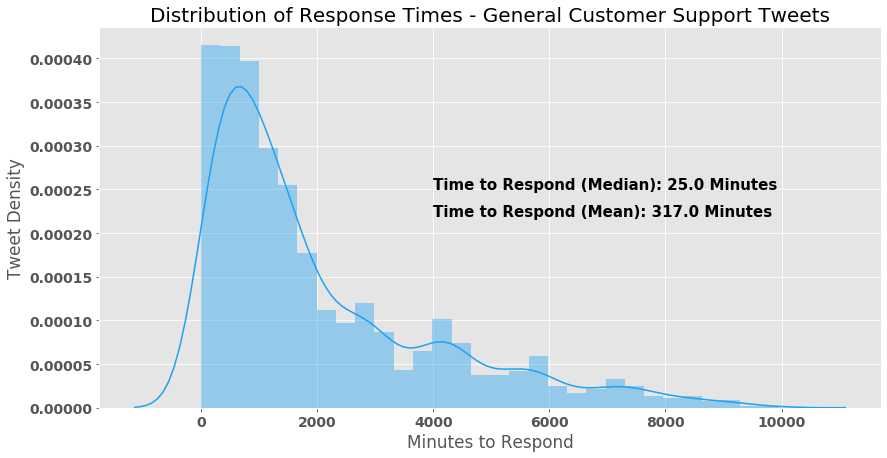

In [329]:
# Plotting the distribution of reponse time per topic
fig, ax = plt.subplots(figsize = (14,7))

sns.distplot(bill_pay_10000.minutes_to_respond, hist = True, color = '#1DA1F2')
plt.xlabel('Minutes to Respond')
plt.ylabel('Tweet Density')

plt.title('Distribution of Response Times - General Customer Support Tweets', fontsize = 20)
plt.text(s = 'Time to Respond (Median): 25.0 Minutes', x = 4000, y = 0.00025, fontsize = 15)
plt.text(s = 'Time to Respond (Mean): 317.0 Minutes', x = 4000, y = 0.00022, fontsize = 15)

plt.savefig('../graphs/Distribution_of_Response_Times_Billing.png', dpi = 500, bbox_inches='tight');

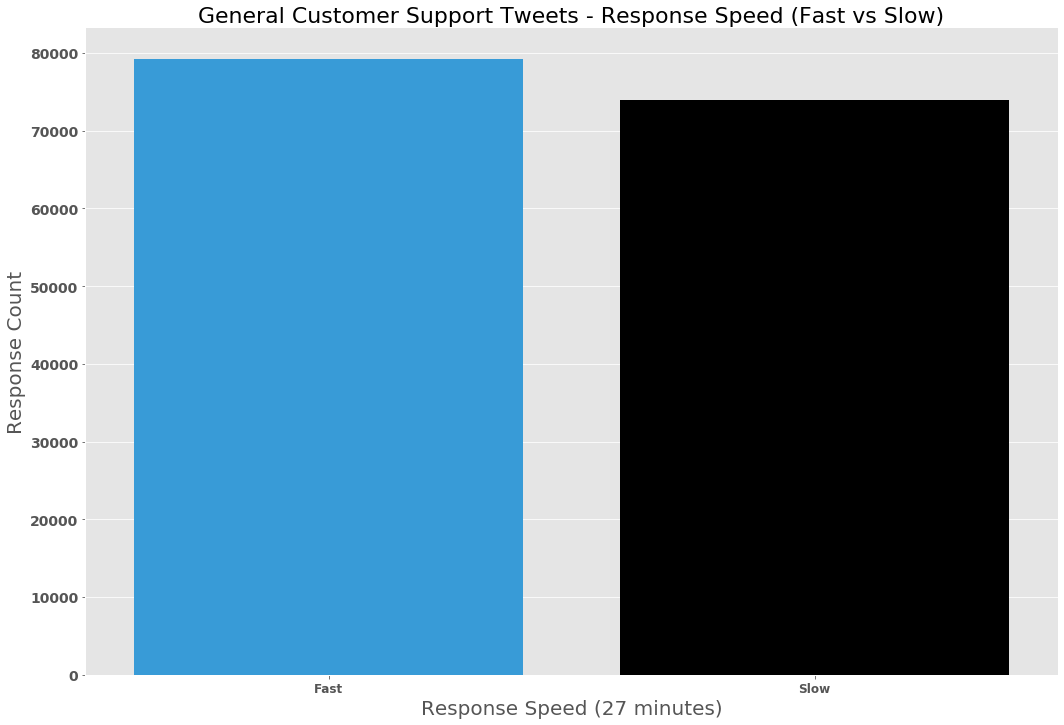

In [311]:
gen_speed = pd.DataFrame(gen_cust_sup.groupby('Reponse_Speed').count()['customer_tweet_id']).reset_index()


clrs = ['#1DA1F2' if (x == max(gen_speed.customer_tweet_id)) else 'black' for x in gen_speed.customer_tweet_id]
sns.catplot(x="Reponse_Speed", y="customer_tweet_id", data=gen_speed, kind="bar", palette = clrs, height = 10, aspect = 1.5)
plt.title("General Customer Support Tweets - Response Speed (Fast vs Slow)", fontsize = 22)
plt.ylabel('Response Count', fontsize = 20)
plt.xlabel('Response Speed (27 minutes)', fontsize = 20)
plt.xticks(fontsize=12)

# plt.savefig('../graphs/General_Customer_Support_Speed.png', dpi = 500, bbox_inches = 'tight');

In [273]:
bill_pay_10000 = bill_pay_sup[bill_pay_sup['minutes_to_respond'] <= 10000]
bill_pay_10000 = bill_pay_10000.groupby('minutes_to_respond').sum().reset_index()
bill_pay_10000.set_index('customer_tweet_id', inplace = True)

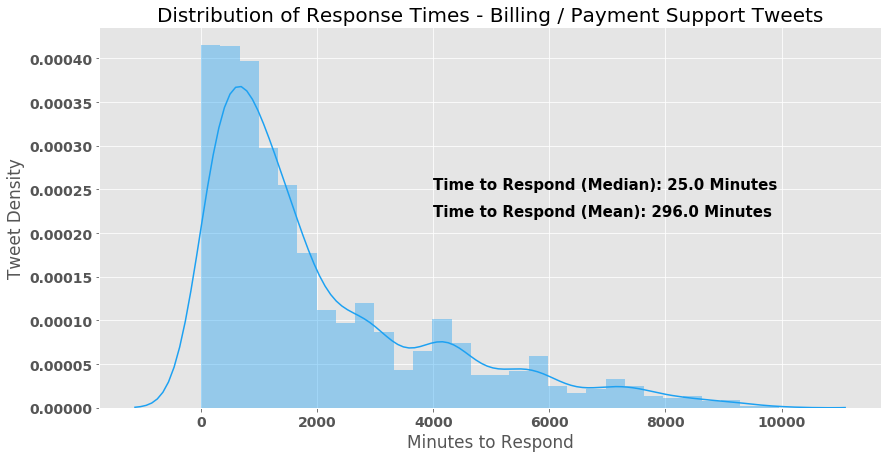

In [327]:
# Plotting the distribution of reponse time per topic
fig, ax = plt.subplots(figsize = (14,7))

sns.distplot(bill_pay_10000.minutes_to_respond, hist = True, color = '#1DA1F2')
plt.xlabel('Minutes to Respond')
plt.ylabel('Tweet Density')

plt.title('Distribution of Response Times - Billing / Payment Support Tweets', fontsize = 20)
plt.text(s = 'Time to Respond (Median): 25.0 Minutes', x = 4000, y = 0.00025, fontsize = 15)
plt.text(s = 'Time to Respond (Mean): 296.0 Minutes', x = 4000, y = 0.00022, fontsize = 15)

# plt.savefig('../graphs/Distribution_of_Response_Times_Billing.png', dpi = 500, bbox_inches='tight');

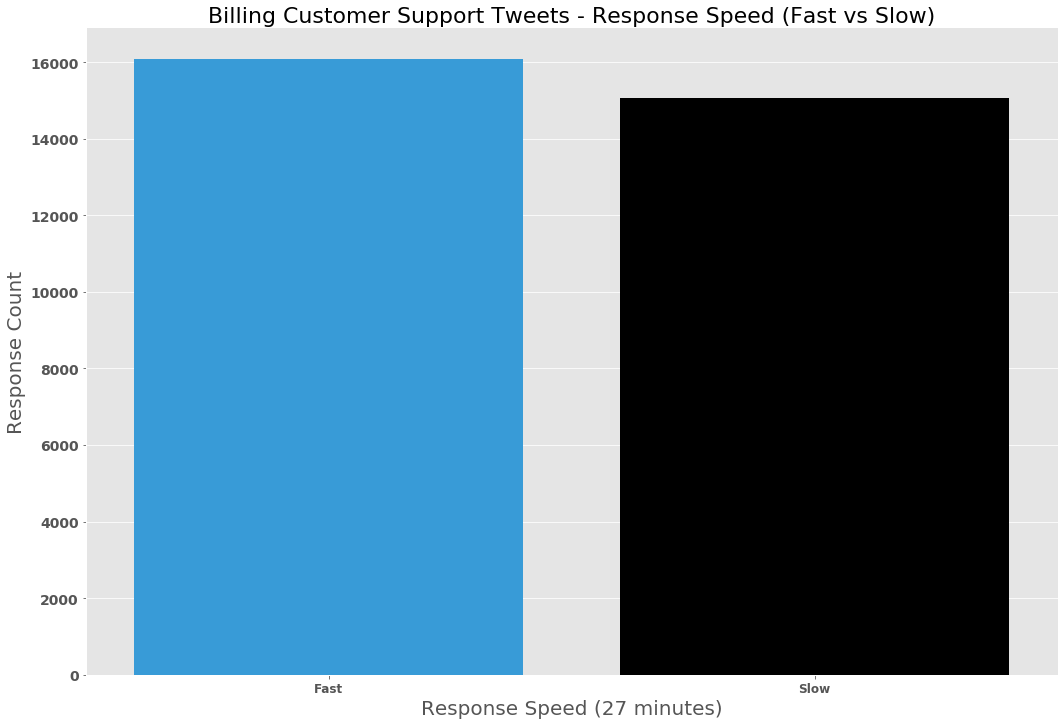

In [332]:
bill_speed = pd.DataFrame(bill_pay_sup.groupby('Reponse_Speed').count()['customer_tweet_id']).reset_index()


clrs = ['#1DA1F2' if (x == max(bill_speed.customer_tweet_id)) else 'black' for x in bill_speed.customer_tweet_id]
sns.catplot(x="Reponse_Speed", y="customer_tweet_id", data=bill_speed, kind="bar", palette = clrs, height = 10, aspect = 1.5)
plt.title("Billing Customer Support Tweets - Response Speed (Fast vs Slow)", fontsize = 22)
plt.ylabel('Response Count', fontsize = 20)
plt.xlabel('Response Speed (27 minutes)', fontsize = 20)
plt.xticks(fontsize=12)

# plt.savefig('../graphs/Billing_Customer_Support_Speed.png', dpi = 500, bbox_inches = 'tight');

In [377]:
food_sup_10000 = food_sup[food_sup['minutes_to_respond'] <= 10000]

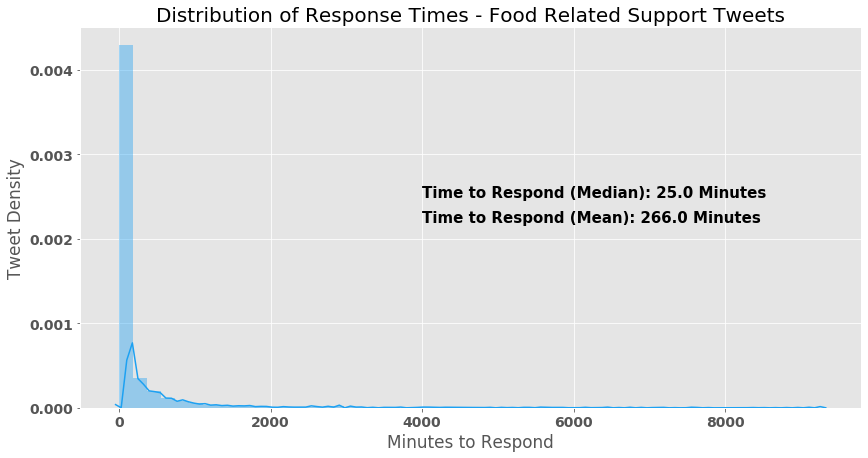

In [378]:
# Plotting the distribution of reponse time per topic
fig, ax = plt.subplots(figsize = (14,7))

sns.distplot(food_sup_10000.minutes_to_respond, hist = True, color = '#1DA1F2')
plt.xlabel('Minutes to Respond')
plt.ylabel('Tweet Density')

plt.title('Distribution of Response Times - Food Related Support Tweets', fontsize = 20)
plt.text(s = 'Time to Respond (Median): 25.0 Minutes', x = 4000, y = 0.0025, fontsize = 15)
plt.text(s = 'Time to Respond (Mean): 266.0 Minutes', x = 4000, y = 0.0022, fontsize = 15)

plt.savefig('../graphs/Distribution_of_Response_Times_Food.png', dpi = 500, bbox_inches='tight');

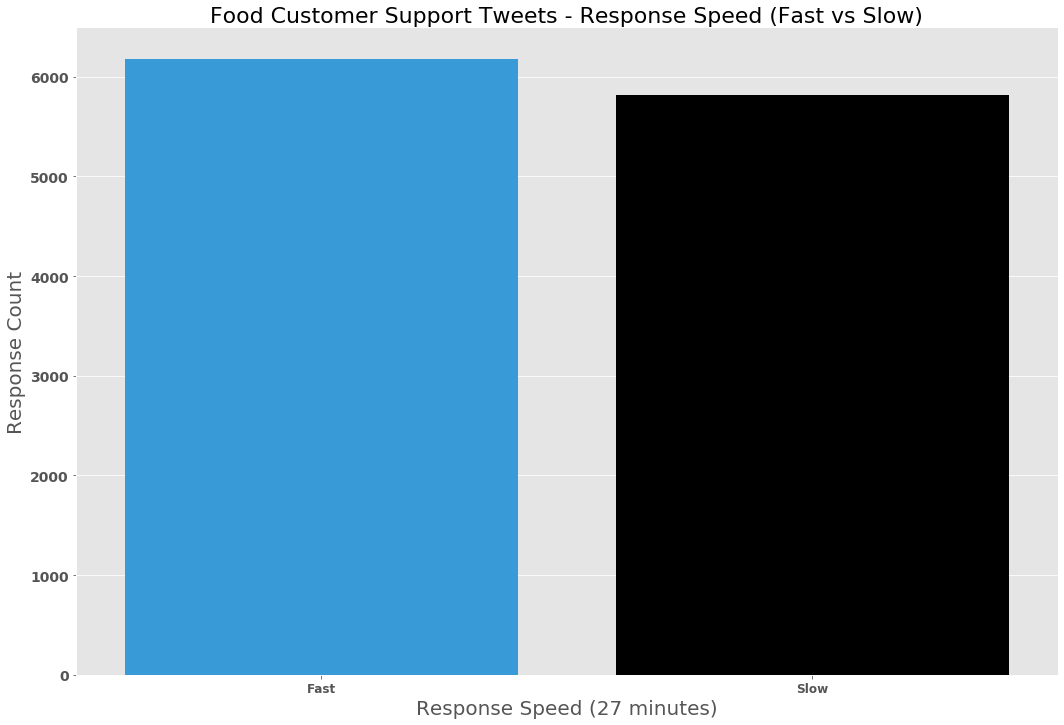

In [380]:
food_speed = pd.DataFrame(food_sup.groupby('Reponse_Speed').count()['customer_tweet_id']).reset_index()


clrs = ['#1DA1F2' if (x == max(food_speed.customer_tweet_id)) else 'black' for x in food_speed.customer_tweet_id]
sns.catplot(x="Reponse_Speed", y="customer_tweet_id", data=food_speed, kind="bar", palette = clrs, height = 10, aspect = 1.5)
plt.title("Food Customer Support Tweets - Response Speed (Fast vs Slow)", fontsize = 22)
plt.ylabel('Response Count', fontsize = 20)
plt.xlabel('Response Speed (27 minutes)', fontsize = 20)
plt.xticks(fontsize=12)

plt.savefig('../graphs/Food_Customer_Support_Speed.png', dpi = 500, bbox_inches = 'tight');

In [431]:
food_sup.iloc[5]

customer_tweet_id        115974                                                                                    
day_tweeted              Thursday                                                                                  
original_text            I guess my soccer player costume wasn't good enough for a $3 burrito @ChipotleTweets      
company_name             ChipotleTweets                                                                            
company_response_text    @115974 That doesn't sound right. Please tell us more here: https://t.co/Ax7W1Dx3Y9 -Becky
minutes_to_respond       12                                                                                        
Reponse_Speed            Fast                                                                                      
customer_tweet_text      guess soccer player costume wasnt good enough burrito                                     
data_lemmatized          ['soccer', 'player', 'costume']                